## Delineate basins

The first step when building a model is to define the model domain. For hydrological models this is typically a full **basin** or **sub-basin** which includes all upstream cells. For hydrodynamic models this can also be an **inter-basin** which does not necessary include all upstream cells. *hydroMT* has the `get_basin_geometry` function to do just that. 

### Import packages

In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from pprint import pprint

In [2]:
# for plotting
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs

proj = ccrs.PlateCarree()  # plot projection

In [3]:
# import hydromt
import hydromt
from hydromt.workflows import get_basin_geometry

In [4]:
# setup logging
from hydromt.log import setuplog

logger = setuplog("basin_delineation", log_level=10)

2022-02-21 14:54:20,750 - basin_delineation - log - INFO - HydroMT version: 0.4.6.dev


### Read data

Read data using the `DataCatalog`. If no yml files with data sources are provided, by default data for the Piave basin is downloaded from the hydromt-artifacts to to `~/.hydromt_data/`. Links to the original data sources and data licenses can be found in the meta dict of each source. Here we use flow direction data from [MERIT Hydro](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro). Note that the original `'MERIT Hydro'` data has been extended with a basin mask layer,
which together with the basin index vector data makes faster basin delineation possible.

In [5]:
# instantiate instance of Data Catalog
data_catalog = hydromt.DataCatalog(logger=logger)

In [6]:
# read MERIT hydro flow direction data
pprint(data_catalog["merit_hydro"].meta)
ds = data_catalog.get_rasterdataset("merit_hydro")

2022-02-21 14:54:20,844 - basin_delineation - data_adapter - INFO - Downloading file to /home/runner/.hydromt_data/data/v0.0.6/data.tar.gz


2022-02-21 14:54:21,291 - basin_delineation - data_adapter - DEBUG - Unpacking data from /home/runner/.hydromt_data/data/v0.0.6/data.tar.gz


2022-02-21 14:54:22,189 - basin_delineation - data_adapter - INFO - Adding sample data v0.0.6 from artifacts


{'category': 'topography',
 'paper_doi': '10.1029/2019WR024873',
 'paper_ref': 'Yamazaki et al. (2019)',
 'source_license': 'CC-BY-NC 4.0 or ODbL 1.0',
 'source_url': 'http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro',
 'source_version': 1.0}
2022-02-21 14:54:22,257 - basin_delineation - data_adapter - INFO - DataCatalog: Getting merit_hydro RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.6/merit_hydro/{variable}.tif


In [7]:
# read MERIT hydro basin index vector data. This data contains bounding box geometries of all basins globally.
# Here we pass the GeoDataFrameAdapter instead of the GeoDataFrame itself
# a spatial subset of the data loaded within the get_basin_geometry method
pprint(data_catalog["merit_hydro_index"].meta)
basin_index = data_catalog["merit_hydro_index"]

{'category': 'topography',
 'paper_doi': '10.5194/hess-2020-582',
 'paper_ref': 'Eilander et al. (in review)',
 'source_license': 'CC-BY-NC 4.0'}


In [8]:
# derive river geometry based on stream order >= 7 (for plotting only)
flwdir = hydromt.flw.flwdir_from_da(ds["flwdir"], ftype="d8")
feats = flwdir.streams(mask=ds["strord"] >= 7)
gdf_riv = gpd.GeoDataFrame.from_features(feats)


def plot(extent, gdf_bas, gdf_out):
    fig = plt.figure(figsize=(6, 8))
    ax = plt.subplot(projection=proj)
    ax.set_extent(extent, crs=proj)
    ax.add_image(cimgt.QuadtreeTiles(), 12)
    gdf_bas.boundary.plot(ax=ax, edgecolor="k", zorder=2)
    gdf_riv.plot(ax=ax, color="blue", alpha=0.7)
    gdf_out.plot(ax=ax, markersize=40, c="red", zorder=2)
    return ax

### Delineate basins

Several examples to delineate sub-, inter- or full basins are provided below. Together with the command line interface (CLI) syntax for the `hydromt build` command. All CLI options are described in the `parse_region` method.

Get the basin based on a point location `[x, y]`.

In [9]:
# CLI syntax: {'basin': [x, y]}
# e.g.: {'basin': [12.6, 45.8]}

xy = [12.6, 45.8]
gdf_bas, _ = get_basin_geometry(
    ds,
    kind="basin",
    xy=xy,
    basin_index=basin_index,
    logger=logger,
)

2022-02-21 14:54:26,033 - basin_delineation - basin_mask - DEBUG - Getting basin IDs at point locations.


2022-02-21 14:54:26,160 - basin_delineation - basin_mask - INFO - basin bbox: [12.1958, 45.5850, 12.8983, 46.4167]


<GeoAxesSubplot:>

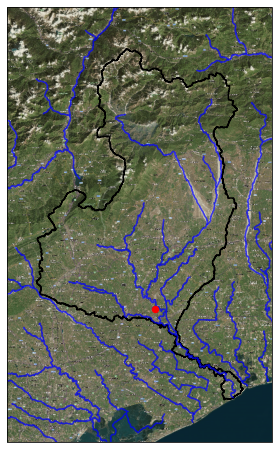

In [10]:
# plot results
gdf_xy = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=[xy[0]], y=[xy[1]]), crs=4326)
extent = np.array(gdf_bas.buffer(0.1).total_bounds)[[0, 2, 1, 3]]

plot(extent, gdf_bas, gdf_xy)

### Delineate sub-basins

We need an initial bounding box to delineate the sub-basin. This can be derived from the *merit_hydro_index* or user provided initial `bounds`. 
The latter might be faster if delineating a small sub-basin from a large basin. A warning is raised if not all contributing cells are included.

Get a subbasin based on its outlet location `[x,y]`, snapped to a stream defined by a `<variable>:<threshold>` pair, in this case a stream order larger or equal to 7. The `variable` should be present in the dataset `ds`. 

In [11]:
# CLI syntax: {'subbasin': [x, y], <variable>: <threshold>, 'bounds': [xmin, ymin, xmax, ymax]}
# e.g.: {'subbasin': [12.6, 45.8], 'strord': 7, 'bounds': [12.1, 45.5, 12.9, 46.5]}

xy = [12.6, 45.8]
bounds = [12.1, 45.5, 12.9, 46.5]
gdf_bas, gdf_out = get_basin_geometry(
    ds,
    kind="subbasin",
    xy=xy,
    strord=7,
    bounds=bounds,
    logger=logger,
)

2022-02-21 14:54:34,905 - basin_delineation - basin_mask - INFO - subbasin bbox: [12.2350, 45.7950, 12.8783, 46.4167]


<GeoAxesSubplot:>

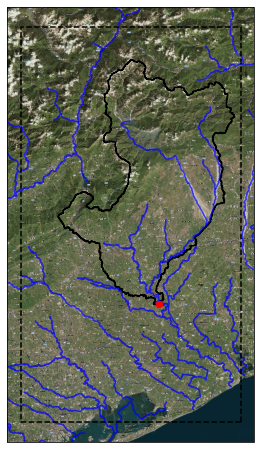

In [12]:
# plot results
gdf_bounds = gpd.GeoDataFrame(geometry=[box(*bounds)], crs=4326)
extent = gdf_bounds.buffer(0.05).total_bounds[[0, 2, 1, 3]]

ax = plot(extent, gdf_bas, gdf_out)
gdf_bounds.boundary.plot(ax=ax, edgecolor="k", ls="--")

Get a sub-basin based on the location where the stream flows out of a `bbox`. Here the stream defined by a `<variable>:<threshold>` pair, in this case a stream order larger or equal to 8. The `variable` should be present in the dataset `ds`. 

In [13]:
# CLI SYNTAX: {'subbasin': [xmin, ymin, xmax, ymax], <variable>: <threshold>}
# e.g.: {'subbasin': [12.50, 45.72, 12.7, 46], 'strord': 8}

bbox = [12.50, 45.72, 12.7, 46]
gdf_bas, gdf_out = get_basin_geometry(
    ds,
    kind="subbasin",
    bbox=bbox,
    strord=8,
    basin_index=basin_index,
    logger=logger,
)

2022-02-21 14:54:41,362 - basin_delineation - basin_mask - DEBUG - Getting IDs of intersecting basins.


2022-02-21 14:54:41,761 - basin_delineation - basin_mask - INFO - subbasin bbox: [12.1958, 45.7192, 12.8783, 46.4167]


<GeoAxesSubplot:>

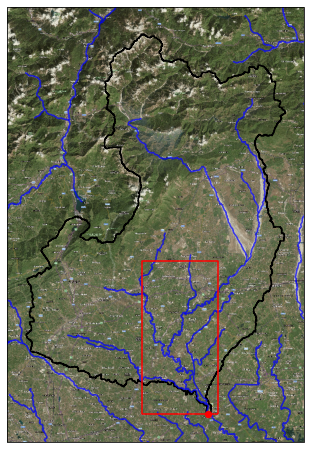

In [14]:
# plot results
gdf_bbox = gpd.GeoDataFrame(geometry=[box(*bbox)], crs=4326)
extent = gdf_bas.buffer(0.05).total_bounds[[0, 2, 1, 3]]

ax = plot(extent, gdf_bas, gdf_out)
gdf_bbox.boundary.plot(ax=ax, edgecolor="r", ls="-")

### Delineate interbasins

Get an inter-basin based on the streams within a `bbox`. The inter-basin is limited to the most downstream contiguous area within the bbox that drains to the stream.  Here the stream defined by a `<variable>:<threshold>` pair, in this case a stream order larger or equal to 8. The `variable` should be present in the dataset `ds`. The `buffer` is required to check wether streams flow in and out of the bbox. 

In [15]:
# CLI SYNTAX {'interbasin': [xmin, ymin, xmax, ymax], <variable>: <threshold>}
# e.g.: {'interbasin': [12.50, 45.72, 12.7, 46], 'strord': 8}

bbox = [12.50, 45.72, 12.7, 46]
gdf_bas, gdf_out = get_basin_geometry(
    ds,
    kind="interbasin",
    bbox=bbox,
    strord=8,
    buffer=20,
    logger=logger,
)

2022-02-21 14:54:48,277 - basin_delineation - basin_mask - INFO - interbasin bbox: [12.5000, 45.7200, 12.7000, 46.0000]


<GeoAxesSubplot:>

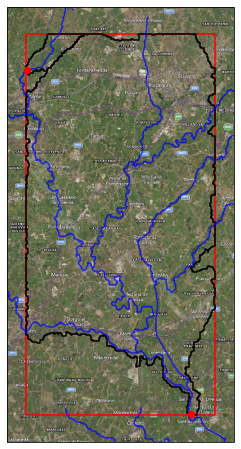

In [16]:
# plot results
gdf_bbox = gpd.GeoDataFrame(geometry=[box(*bbox)], crs=4326)
extent = gdf_bbox.buffer(0.02).total_bounds[[0, 2, 1, 3]]

ax = plot(extent, gdf_bas, gdf_out)
gdf_bbox.boundary.plot(ax=ax, edgecolor="r", ls="-", zorder=1)